<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB3] - Training monitoring
<!-- DESC --> Episode 3 : Monitoring, analysis and check points during a training session
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

## What we're going to do :

 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery points

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix
from skimage import io, transform, color

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB3.001'
datasets_dir = pwk.init('GTSRB3', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB3_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : GTSRB3
Run time             : Wednesday 10 February 2021, 09:17:19
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB3_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB3_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  3'30 on a CPU laptop.

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

# enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 208ms)


## Step 3 - Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


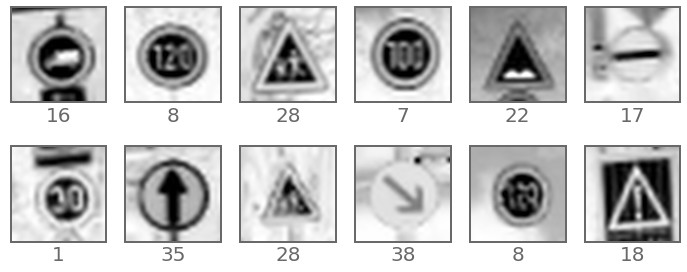

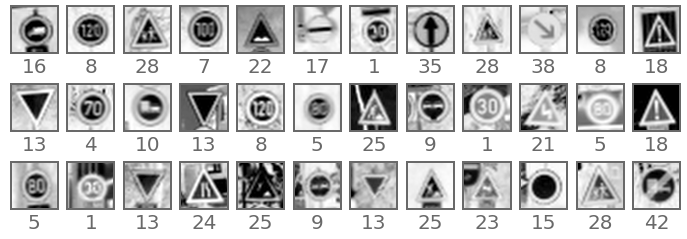

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models... 

In [6]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [7]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

print(f'To run tensorboard, use :  --logdir {run_dir}/logs')

To run tensorboard, use :  --logdir ./run/GTSRB3_done/logs


## Step 6 - Train the model
**Get the shape of my data :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note: The training curve is visible in real time with Tensorboard (see step  5)

In [10]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5


  1/613 [..............................] - ETA: 29:33 - loss: 3.7533 - accuracy: 0.0156

  3/613 [..............................] - ETA: 41s - loss: 3.6986 - accuracy: 0.0417  

 22/613 [>.............................] - ETA: 5s - loss: 3.5878 - accuracy: 0.0595 

 41/613 [=>............................] - ETA: 3s - loss: 3.5657 - accuracy: 0.0630

 60/613 [=>............................] - ETA: 2s - loss: 3.5462 - accuracy: 0.0670

 79/613 [==>...........................] - ETA: 2s - loss: 3.5221 - accuracy: 0.0729

 99/613 [===>..........................] - ETA: 2s - loss: 3.4888 - accuracy: 0.0825

119/613 [====>.........................] - ETA: 1s - loss: 3.4435 - accuracy: 0.0953

139/613 [=====>........................] - ETA: 1s - loss: 3.3875 - accuracy: 0.1105

159/613 [======>.......................] - ETA: 1s - loss: 3.3237 - accuracy: 0.1273

179/613 [=======>......................] - ETA: 1s - loss: 3.2572 - accuracy: 0.1444

199/613 [========>.....................] - ETA: 1s - loss: 3.1904 - accuracy: 0.1613

219/613 [=========>....................] - ETA: 1s - loss: 3.1241 - accuracy: 0.1780

239/613 [==========>...................] - ETA: 1s - loss: 3.0584 - accuracy: 0.1945

259/613 [===========>..................] - ETA: 1s - loss: 2.9944 - accuracy: 0.2104

279/613 [============>.................] - ETA: 1s - loss: 2.9324 - accuracy: 0.2259

299/613 [=============>................] - ETA: 0s - loss: 2.8728 - accuracy: 0.2408

319/613 [==============>...............] - ETA: 0s - loss: 2.8156 - accuracy: 0.2552

339/613 [===============>..............] - ETA: 0s - loss: 2.7608 - accuracy: 0.2689

359/613 [================>.............] - ETA: 0s - loss: 2.7082 - accuracy: 0.2821

379/613 [=================>............] - ETA: 0s - loss: 2.6578 - accuracy: 0.2947

399/613 [==================>...........] - ETA: 0s - loss: 2.6094 - accuracy: 0.3069

419/613 [===================>..........] - ETA: 0s - loss: 2.5629 - accuracy: 0.3187

439/613 [====================>.........] - ETA: 0s - loss: 2.5184 - accuracy: 0.3300

459/613 [=====================>........] - ETA: 0s - loss: 2.4756 - accuracy: 0.3408

479/613 [======================>.......] - ETA: 0s - loss: 2.4345 - accuracy: 0.3513

499/613 [=======================>......] - ETA: 0s - loss: 2.3951 - accuracy: 0.3614

519/613 [========================>.....] - ETA: 0s - loss: 2.3571 - accuracy: 0.3711

539/613 [=========================>....] - ETA: 0s - loss: 2.3206 - accuracy: 0.3805

559/613 [==========================>...] - ETA: 0s - loss: 2.2853 - accuracy: 0.3896

579/613 [===========================>..] - ETA: 0s - loss: 2.2514 - accuracy: 0.3983

599/613 [============================>.] - ETA: 0s - loss: 2.2186 - accuracy: 0.4067

613/613 [==============================] - ETA: 0s - loss: 2.1964 - accuracy: 0.4125

613/613 [==============================] - 6s 5ms/step - loss: 2.1948 - accuracy: 0.4129 - val_loss: 0.4809 - val_accuracy: 0.8842


Epoch 2/5
  1/613 [..............................] - ETA: 1s - loss: 0.2495 - accuracy: 0.9375

 21/613 [>.............................] - ETA: 1s - loss: 0.3238 - accuracy: 0.9043

 41/613 [=>............................] - ETA: 1s - loss: 0.3171 - accuracy: 0.9049

 61/613 [=>............................] - ETA: 1s - loss: 0.3111 - accuracy: 0.9071

 81/613 [==>...........................] - ETA: 1s - loss: 0.3070 - accuracy: 0.9087

101/613 [===>..........................] - ETA: 1s - loss: 0.3036 - accuracy: 0.9099

121/613 [====>.........................] - ETA: 1s - loss: 0.3010 - accuracy: 0.9107

142/613 [=====>........................] - ETA: 1s - loss: 0.2984 - accuracy: 0.9115

163/613 [======>.......................] - ETA: 1s - loss: 0.2963 - accuracy: 0.9122

183/613 [=======>......................] - ETA: 1s - loss: 0.2942 - accuracy: 0.9129

203/613 [========>.....................] - ETA: 1s - loss: 0.2923 - accuracy: 0.9135

223/613 [=========>....................] - ETA: 0s - loss: 0.2904 - accuracy: 0.9141

243/613 [==========>...................] - ETA: 0s - loss: 0.2889 - accuracy: 0.9146

263/613 [===========>..................] - ETA: 0s - loss: 0.2876 - accuracy: 0.9150

284/613 [============>.................] - ETA: 0s - loss: 0.2863 - accuracy: 0.9155

304/613 [=============>................] - ETA: 0s - loss: 0.2849 - accuracy: 0.9160

324/613 [==============>...............] - ETA: 0s - loss: 0.2835 - accuracy: 0.9165

345/613 [===============>..............] - ETA: 0s - loss: 0.2822 - accuracy: 0.9169

365/613 [================>.............] - ETA: 0s - loss: 0.2809 - accuracy: 0.9174

386/613 [=================>............] - ETA: 0s - loss: 0.2795 - accuracy: 0.9178

406/613 [==================>...........] - ETA: 0s - loss: 0.2782 - accuracy: 0.9183

427/613 [===================>..........] - ETA: 0s - loss: 0.2767 - accuracy: 0.9188

448/613 [====================>.........] - ETA: 0s - loss: 0.2753 - accuracy: 0.9192

468/613 [=====================>........] - ETA: 0s - loss: 0.2739 - accuracy: 0.9197

489/613 [======================>.......] - ETA: 0s - loss: 0.2726 - accuracy: 0.9201

509/613 [=======================>......] - ETA: 0s - loss: 0.2713 - accuracy: 0.9205

529/613 [========================>.....] - ETA: 0s - loss: 0.2700 - accuracy: 0.9209

550/613 [=========================>....] - ETA: 0s - loss: 0.2687 - accuracy: 0.9213

570/613 [==========================>...] - ETA: 0s - loss: 0.2675 - accuracy: 0.9217

590/613 [===========================>..] - ETA: 0s - loss: 0.2663 - accuracy: 0.9221

610/613 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.9225

613/613 [==============================] - 2s 3ms/step - loss: 0.2648 - accuracy: 0.9225 - val_loss: 0.3554 - val_accuracy: 0.9169


Epoch 3/5
  1/613 [..............................] - ETA: 1s - loss: 0.1152 - accuracy: 0.9844

 21/613 [>.............................] - ETA: 1s - loss: 0.1523 - accuracy: 0.9551

 41/613 [=>............................] - ETA: 1s - loss: 0.1566 - accuracy: 0.9521

 61/613 [=>............................] - ETA: 1s - loss: 0.1587 - accuracy: 0.9521

 81/613 [==>...........................] - ETA: 1s - loss: 0.1599 - accuracy: 0.9522

101/613 [===>..........................] - ETA: 1s - loss: 0.1598 - accuracy: 0.9526

121/613 [====>.........................] - ETA: 1s - loss: 0.1590 - accuracy: 0.9530

141/613 [=====>........................] - ETA: 1s - loss: 0.1586 - accuracy: 0.9532

161/613 [======>.......................] - ETA: 1s - loss: 0.1583 - accuracy: 0.9533

181/613 [=======>......................] - ETA: 1s - loss: 0.1578 - accuracy: 0.9535

201/613 [========>.....................] - ETA: 1s - loss: 0.1569 - accuracy: 0.9538

221/613 [=========>....................] - ETA: 0s - loss: 0.1561 - accuracy: 0.9540

241/613 [==========>...................] - ETA: 0s - loss: 0.1554 - accuracy: 0.9542

261/613 [===========>..................] - ETA: 0s - loss: 0.1548 - accuracy: 0.9544

281/613 [============>.................] - ETA: 0s - loss: 0.1542 - accuracy: 0.9546

301/613 [=============>................] - ETA: 0s - loss: 0.1537 - accuracy: 0.9548

321/613 [==============>...............] - ETA: 0s - loss: 0.1532 - accuracy: 0.9550

341/613 [===============>..............] - ETA: 0s - loss: 0.1527 - accuracy: 0.9552

361/613 [================>.............] - ETA: 0s - loss: 0.1521 - accuracy: 0.9554

382/613 [=================>............] - ETA: 0s - loss: 0.1516 - accuracy: 0.9556

402/613 [==================>...........] - ETA: 0s - loss: 0.1510 - accuracy: 0.9558

422/613 [===================>..........] - ETA: 0s - loss: 0.1505 - accuracy: 0.9560

443/613 [====================>.........] - ETA: 0s - loss: 0.1500 - accuracy: 0.9562

463/613 [=====================>........] - ETA: 0s - loss: 0.1494 - accuracy: 0.9564

483/613 [======================>.......] - ETA: 0s - loss: 0.1489 - accuracy: 0.9565

503/613 [=======================>......] - ETA: 0s - loss: 0.1484 - accuracy: 0.9567

523/613 [========================>.....] - ETA: 0s - loss: 0.1479 - accuracy: 0.9569

543/613 [=========================>....] - ETA: 0s - loss: 0.1474 - accuracy: 0.9571

563/613 [==========================>...] - ETA: 0s - loss: 0.1469 - accuracy: 0.9572

583/613 [===========================>..] - ETA: 0s - loss: 0.1465 - accuracy: 0.9574

603/613 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9575

613/613 [==============================] - 2s 3ms/step - loss: 0.1458 - accuracy: 0.9576 - val_loss: 0.2796 - val_accuracy: 0.9294


Epoch 4/5
  1/613 [..............................] - ETA: 1s - loss: 0.0646 - accuracy: 0.9688

 21/613 [>.............................] - ETA: 1s - loss: 0.0740 - accuracy: 0.9774

 41/613 [=>............................] - ETA: 1s - loss: 0.0802 - accuracy: 0.9762

 61/613 [=>............................] - ETA: 1s - loss: 0.0843 - accuracy: 0.9752

 81/613 [==>...........................] - ETA: 1s - loss: 0.0869 - accuracy: 0.9746

101/613 [===>..........................] - ETA: 1s - loss: 0.0887 - accuracy: 0.9742

121/613 [====>.........................] - ETA: 1s - loss: 0.0901 - accuracy: 0.9738

141/613 [=====>........................] - ETA: 1s - loss: 0.0909 - accuracy: 0.9735

161/613 [======>.......................] - ETA: 1s - loss: 0.0915 - accuracy: 0.9733

181/613 [=======>......................] - ETA: 1s - loss: 0.0918 - accuracy: 0.9732

201/613 [========>.....................] - ETA: 1s - loss: 0.0918 - accuracy: 0.9731

221/613 [=========>....................] - ETA: 0s - loss: 0.0917 - accuracy: 0.9731

242/613 [==========>...................] - ETA: 0s - loss: 0.0916 - accuracy: 0.9731

262/613 [===========>..................] - ETA: 0s - loss: 0.0914 - accuracy: 0.9730

282/613 [============>.................] - ETA: 0s - loss: 0.0913 - accuracy: 0.9730

302/613 [=============>................] - ETA: 0s - loss: 0.0911 - accuracy: 0.9730

322/613 [==============>...............] - ETA: 0s - loss: 0.0909 - accuracy: 0.9730

342/613 [===============>..............] - ETA: 0s - loss: 0.0906 - accuracy: 0.9731

362/613 [================>.............] - ETA: 0s - loss: 0.0904 - accuracy: 0.9731

382/613 [=================>............] - ETA: 0s - loss: 0.0902 - accuracy: 0.9731

402/613 [==================>...........] - ETA: 0s - loss: 0.0901 - accuracy: 0.9732

422/613 [===================>..........] - ETA: 0s - loss: 0.0899 - accuracy: 0.9732

442/613 [====================>.........] - ETA: 0s - loss: 0.0898 - accuracy: 0.9732

462/613 [=====================>........] - ETA: 0s - loss: 0.0896 - accuracy: 0.9733

482/613 [======================>.......] - ETA: 0s - loss: 0.0894 - accuracy: 0.9734

502/613 [=======================>......] - ETA: 0s - loss: 0.0892 - accuracy: 0.9734

522/613 [========================>.....] - ETA: 0s - loss: 0.0890 - accuracy: 0.9735

542/613 [=========================>....] - ETA: 0s - loss: 0.0888 - accuracy: 0.9736

562/613 [==========================>...] - ETA: 0s - loss: 0.0886 - accuracy: 0.9736

582/613 [===========================>..] - ETA: 0s - loss: 0.0884 - accuracy: 0.9737

603/613 [============================>.] - ETA: 0s - loss: 0.0882 - accuracy: 0.9737

613/613 [==============================] - 2s 3ms/step - loss: 0.0881 - accuracy: 0.9737 - val_loss: 0.2952 - val_accuracy: 0.9289


Epoch 5/5
  1/613 [..............................] - ETA: 1s - loss: 0.0737 - accuracy: 0.9688

 21/613 [>.............................] - ETA: 1s - loss: 0.1003 - accuracy: 0.9636

 41/613 [=>............................] - ETA: 1s - loss: 0.0954 - accuracy: 0.9686

 61/613 [=>............................] - ETA: 1s - loss: 0.0907 - accuracy: 0.9711

 81/613 [==>...........................] - ETA: 1s - loss: 0.0874 - accuracy: 0.9726

101/613 [===>..........................] - ETA: 1s - loss: 0.0851 - accuracy: 0.9736

121/613 [====>.........................] - ETA: 1s - loss: 0.0832 - accuracy: 0.9742

141/613 [=====>........................] - ETA: 1s - loss: 0.0816 - accuracy: 0.9747

161/613 [======>.......................] - ETA: 1s - loss: 0.0806 - accuracy: 0.9750

181/613 [=======>......................] - ETA: 1s - loss: 0.0798 - accuracy: 0.9752

201/613 [========>.....................] - ETA: 1s - loss: 0.0792 - accuracy: 0.9754

221/613 [=========>....................] - ETA: 0s - loss: 0.0787 - accuracy: 0.9755

241/613 [==========>...................] - ETA: 0s - loss: 0.0782 - accuracy: 0.9756

261/613 [===========>..................] - ETA: 0s - loss: 0.0776 - accuracy: 0.9757

282/613 [============>.................] - ETA: 0s - loss: 0.0771 - accuracy: 0.9759

302/613 [=============>................] - ETA: 0s - loss: 0.0766 - accuracy: 0.9761

322/613 [==============>...............] - ETA: 0s - loss: 0.0762 - accuracy: 0.9762

343/613 [===============>..............] - ETA: 0s - loss: 0.0758 - accuracy: 0.9763

363/613 [================>.............] - ETA: 0s - loss: 0.0755 - accuracy: 0.9764

384/613 [=================>............] - ETA: 0s - loss: 0.0752 - accuracy: 0.9765

404/613 [==================>...........] - ETA: 0s - loss: 0.0749 - accuracy: 0.9766

424/613 [===================>..........] - ETA: 0s - loss: 0.0746 - accuracy: 0.9767

444/613 [====================>.........] - ETA: 0s - loss: 0.0744 - accuracy: 0.9768

464/613 [=====================>........] - ETA: 0s - loss: 0.0742 - accuracy: 0.9769

484/613 [======================>.......] - ETA: 0s - loss: 0.0740 - accuracy: 0.9769

504/613 [=======================>......] - ETA: 0s - loss: 0.0739 - accuracy: 0.9770

524/613 [========================>.....] - ETA: 0s - loss: 0.0737 - accuracy: 0.9771

544/613 [=========================>....] - ETA: 0s - loss: 0.0735 - accuracy: 0.9772

564/613 [==========================>...] - ETA: 0s - loss: 0.0734 - accuracy: 0.9772

584/613 [===========================>..] - ETA: 0s - loss: 0.0732 - accuracy: 0.9773

604/613 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9774

613/613 [==============================] - 2s 3ms/step - loss: 0.0729 - accuracy: 0.9774 - val_loss: 0.2537 - val_accuracy: 0.9402



Duration :  00:00:18 474ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9402


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2537
Test accuracy  : 0.9402


## Step 7 - History
The return of model.fit() returns us the learning history

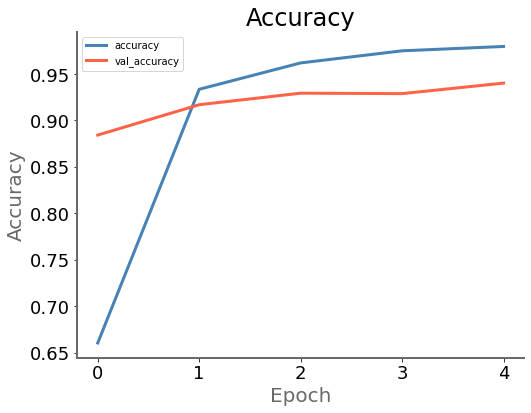

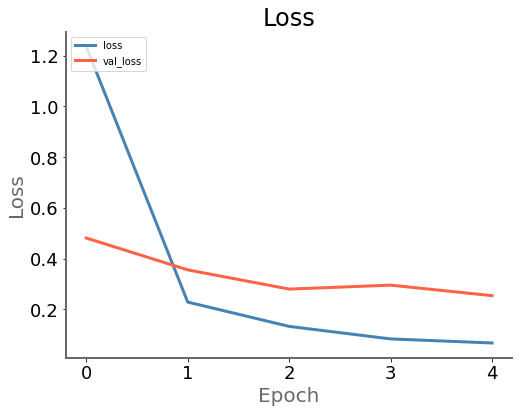

In [13]:
pwk.plot_history(history, save_as='03-history')

## Step 8 - Evaluation and confusion

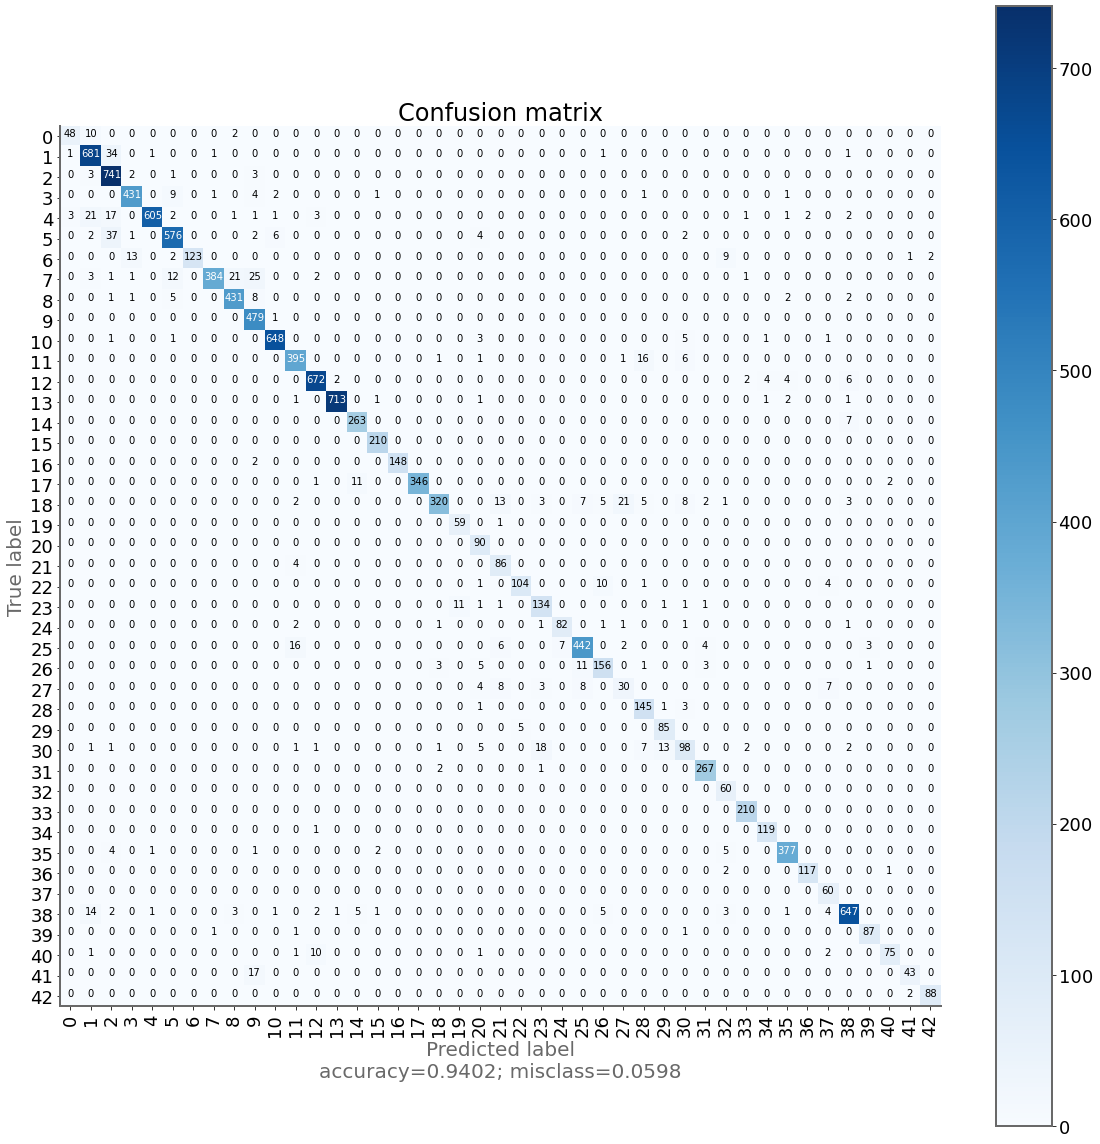

In [14]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, save_as='04-confusion-matrix')

## Step 9 - Restore and evaluate
### 9.1 - List saved models :

In [15]:
!find "$run_dir"/models/

./run/GTSRB3_done/models/
./run/GTSRB3_done/models/last-model.h5
./run/GTSRB3_done/models/model-0002.h5
./run/GTSRB3_done/models/model-0004.h5
./run/GTSRB3_done/models/best-model.h5
./run/GTSRB3_done/models/model-0005.h5
./run/GTSRB3_done/models/model-0001.h5
./run/GTSRB3_done/models/model-0003.h5


### 9.2 - Restore a model :

In [16]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 9.3 - Evaluate it :

In [17]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2537
Test accuracy  : 0.9402


### 9.4 - Make a prediction :


Output layer from model is (x100) :

[[ 0.    0.    0.    0.    0.    0.    0.    0.01 99.99  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]

Graphically :



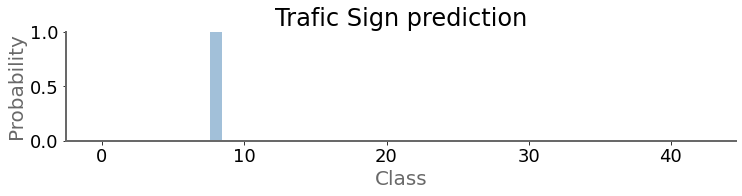


The image :               Prediction :            Real stuff:


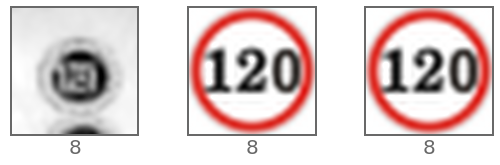

YEEES ! that's right!


In [18]:
# ---- Get a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))
plt.xlabel('Class')
plt.title('Trafic Sign prediction')
pwk.save_fig('05-prediction-proba')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :               Prediction :            Real stuff:")
pwk.plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=3, y_size=2, save_as='06-prediction-images')

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong ;-(")

In [19]:
pwk.end()

End time is : Wednesday 10 February 2021, 09:18:18
Duration is : 00:00:59 569ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Limit model saving: 1 save every 5 epochs </li>
        <li>Use a subset of the dataset</li>
        <li>Try different datasets</li>
        <li>Some exotic signs are waiting to be recognized in dataset_dir/extra !</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>